In [1]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from data_loading import *
import matplotlib.pyplot as plt

Original Paper 
https://web.stanford.edu/~hastie/Papers/spca_JASA.pdf

Steps in brief:
1. Compute (univariate) standard regression coefficients for each feature.
2. Form a reduced data matrix consisting of only those features whose univariate coefficient exceeds a threshold θ in absolute value (θ is estimated by cross-validation).
3. Compute the first (or first few) principal components of the reduced data matrix.
4. Use these principal component(s) in a regression model to predict the outcome.

In [2]:
class spca_model():
    
    def __init__(self, model=None, threshold=0, n_components=0):    
        self._model = model
        self._threshold = threshold
        self._n_components = n_components
        
        self._dropouts = None
        self._pca = None
        
    
    def fit_spca_model(self, x, y):
        x_extra_dim = x[:, np.newaxis]  # Change dimension from (x,y) to (x,1,y)
        # x.reshape(x.shape + (1,))
        
        self._dropouts = []
        
        # Fit each feature with the target (predictor) and if the coefficient is less than the threshold, drop it
        for i in range(0, x_extra_dim.shape[2]): # iterate over all the features
            x_one_feature = x_extra_dim[:, :, i]
            self._model.fit(x_one_feature, y)
            
            if (all([abs(self._model.coef_[0]) < self._threshold])): # Return True if True for all values in the list
                self._dropouts.append(i)
                
        if (len(self._dropouts) == x_extra_dim.shape[2]):  # all features have coef less than the threshold
            raise ValueError('Try a smaller threshold')
            
        if (self._n_components > 0):  # calculate the most important n_components
            self._pca = PCA(n_components=self._n_components)
        else: # if n_components is not more than 0. then all components are kept
            self._pca = PCA(n_components=x_extra_dim.shape[2])
        
        x_transform = self._pca.fit_transform(x_extra_dim[:, 0, :])
        
        self._model = self._model.fit(x_transform, y)
        
        return self

    
    def spca_predict(self, x):
        # delete from x those features which had coef less than the threshold, and were in the dropout set
        trans_x = np.delete(x, self._dropouts, axis=1)  
        
        self._model = self._model.fit(trans_x, y)
        
        # the remaining features have been transformed into components using PCA weights 
        self._pca = PCA(n_components=5)
        x_transform = self._pca.fit_transform(trans_x,y)
        
        # predict using the spca model
        return self._model.predict(x_transform)
    
    
    def get_num_components(self):
        # return the number of components after the pca fit
        return self._pca.n_components_

    
    def get_components(self):
        # shape : (n_components, n_features)
        # Principal axes in feature space, representing the directions of maximum variance in the data.
        # Should be run only after the PCA has been run on the training dataset
        return self._pca.components_

    
    def get_coefficients(self):
        # return the coefs of the model the data has been fit on
        return self._model.coef_
    
    
    def get_score(self, x, y):
        # return score of the reduced dimensional data on the model
        return self._model.score(x, y)
    


In [3]:
X, y = get_data(subsamp=True, binary=True)

In [4]:
n_components=2
#P = PCA(n_components=n_components)
m = LogisticRegression()
model = spca_model(model = m, threshold=0.2)

In [5]:
model.fit_spca_model(X,y)

/home/jvendrow/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [6]:
model.get_num_components()

215

In [7]:
X.shape

(1638, 215)

In [8]:
y_pred = model.spca_predict(X)

/home/jvendrow/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


ValueError: X has 5 features per sample; expecting 120

In [ ]:
y[y==y_pred].shape[0]

In [ ]:
y.shape[0]

In [ ]:
1323/1638

In [ ]:
PCA = model._pca

In [ ]:
PCA.components_.shape

In [21]:
trans_x = np.delete(X, model._dropouts, axis=1) 
#trans_x=X

In [27]:
pca = PCA(n_components=3)
x_transform = pca.fit_transform(trans_x)

In [28]:
pca.components_.shape

(3, 120)

In [29]:
np.count_nonzero(pca.components_)

360

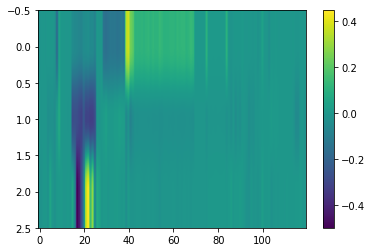

In [30]:
plt.imshow(pca.components_, aspect='auto')
plt.colorbar()
plt.show()

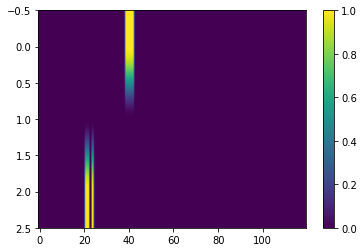

In [31]:
p = pca.components_.copy()
p[p>=0.2] = 1
p[p<0.2] = 0
plt.imshow(p, aspect='auto')
plt.colorbar()
plt.show()

In [32]:
map = {}
drop = model._dropouts
non_dropout = [i for i in range(215) if i not in drop]

In [33]:
#non_dropout = [i for i in range(215)]

In [34]:
A = pca.components_.T
for i in range(A.shape[1]):
    print([non_dropout[x] for x in np.argsort(A[:,i])[::-1][:10]])
    print(A[:,i][np.argsort(A[:,i])[::-1][:10]])

[80, 79, 81, 82, 108, 94, 109, 105, 89, 91]
[0.37404629 0.34626644 0.24291606 0.21449667 0.13618694 0.13315553
 0.12382288 0.12368797 0.12351132 0.12317391]
[23, 70, 76, 77, 78, 74, 75, 21, 69, 184]
[0.07761393 0.03839005 0.03678952 0.02931408 0.02871753 0.02507376
 0.02410699 0.02270967 0.02214224 0.01995027]
[50, 49, 52, 51, 62, 43, 15, 65, 146, 176]
[0.44675141 0.37083413 0.29339443 0.1529368  0.07339452 0.05992362
 0.05527061 0.05042272 0.0296623  0.02917132]


In [35]:
A = pca.components_.T
for i in range(A.shape[1]):
    print([non_dropout[x] for x in np.argsort(A[:,i])[:10]])
    print(A[:,i][np.argsort(A[:,i])[:10]])

[21, 70, 69, 75, 78, 71, 76, 73, 72, 74]
[-0.16729552 -0.15060214 -0.1395381  -0.13903281 -0.13847074 -0.1379889
 -0.13130482 -0.12991454 -0.12551261 -0.12543066]
[51, 52, 47, 49, 50, 46, 54, 43, 45, 44]
[-0.32449336 -0.32221451 -0.31288493 -0.31084645 -0.30549086 -0.29769853
 -0.28256074 -0.27361598 -0.27339269 -0.26779508]
[45, 46, 47, 48, 54, 44, 79, 166, 94, 184]
[-0.49934641 -0.43482445 -0.27422837 -0.09279967 -0.06109459 -0.05405863
 -0.0271638  -0.0230028  -0.02021857 -0.0179068 ]


In [48]:
for i in range(A.shape[1]):
    pos_features = [non_dropout[x] for x in np.argsort(A[:,i])[::-1][:30]]
    pos_ranks = A[:,i][np.argsort(A[:,i])[::-1][:30]]
    neg_features = [non_dropout[x] for x in np.argsort(A[:,i])[:30]]
    neg_ranks = A[:,i][np.argsort(A[:,i])[:30]]
    
    all_features = np.concatenate((pos_features,neg_features))
    all_ranks = np.concatenate((pos_ranks,neg_ranks))
    signs = all_ranks.copy()
    signs[signs>0] = 1
    signs[signs<0] = -1
    all_ranks_abs = np.abs(all_ranks)
    srt = np.argsort(all_ranks_abs)
    final_features = all_features[srt][::-1]
    print(final_features[:10].tolist())
    print(signs[srt][::-1][:10].astype(int).tolist())
    
    

[80, 79, 81, 82, 21, 70, 69, 75, 78, 71]
[1, 1, 1, 1, -1, -1, -1, -1, -1, -1]
[51, 52, 47, 49, 50, 46, 54, 43, 45, 44]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[45, 50, 46, 49, 52, 47, 51, 48, 62, 54]
[-1, 1, -1, 1, 1, -1, 1, -1, 1, -1]


In [20]:
A = pca.components_.T
for i in range(A.shape[1]):
    print([non_dropout[x] for x in np.argsort(A[:,i])[50:60]])
    print(A[:,i][np.argsort(A[:,i])[50:60]])

[35, 41, 177, 193, 110, 196, 62, 61, 174, 214]
[0.00027297 0.00029877 0.00031141 0.00034132 0.00034192 0.00036617
 0.0003729  0.0003853  0.00045341 0.00047267]
[204, 175, 181, 61, 35, 36, 56, 65, 113, 111]
[0.00012568 0.000303   0.00041299 0.00071423 0.00074479 0.00108462
 0.00112452 0.00112578 0.00116037 0.00116778]
[19, 38, 31, 12, 127, 200, 144, 166, 9, 147]
[-0.02148302 -0.02143123 -0.01990706 -0.01948075 -0.01908435 -0.01900592
 -0.01847594 -0.01838425 -0.01825355 -0.01815637]
[199, 23, 17, 14, 38, 160, 166, 44, 163, 16]
[-0.01483413 -0.01279222 -0.01216466 -0.01188916 -0.01187411 -0.01168229
 -0.01151655 -0.0112382  -0.01118545 -0.01097175]
[65, 170, 192, 173, 123, 194, 181, 39, 196, 174]
[-0.00131245 -0.00131128 -0.00098931 -0.00090355 -0.00082385 -0.00079657
 -0.00054055 -0.00049738 -0.00049169 -0.00044625]


In [61]:
X_2 = x_transform[:,0:2]
X_2_non = X_2[y==0]
X_2_high = X_2[y==1]

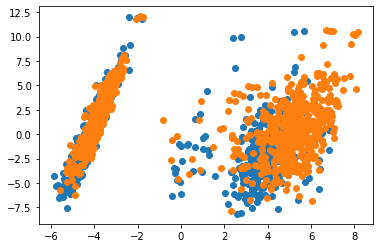

In [63]:
plt.scatter(X_2_non[:,0], X_2_non[:,1])
plt.scatter(X_2_high[:,0], X_2_high[:,1])


plt.show()